In [1]:
import pandas as pd
import numpy as np
from numpy import percentile
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from scipy import stats
from sklearn.preprocessing import MinMaxScaler

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


# Reading the Data

In [2]:
df = pd.read_csv("Anomaly_dataset.csv", encoding='ISO-8859-1', header=0)
df.head().transpose()

,0,1,2,3,4
Row ID,1,2,3,4,5
Order ID,CA-2016-152156,CA-2016-152156,CA-2016-138688,US-2015-108966,US-2015-108966
Order Date,08/11/2016,08/11/2016,12/06/2016,11/10/2015,11/10/2015
Ship Date,11/11/2016,11/11/2016,16/06/2016,18/10/2015,18/10/2015
Ship Mode,Second Class,Second Class,Second Class,Standard Class,Standard Class
Customer ID,CG-12520,CG-12520,DV-13045,SO-20335,SO-20335
Customer Name,Claire Gute,Claire Gute,Darrin Van Huff,Sean O'Donnell,Sean O'Donnell
Segment,Consumer,Consumer,Corporate,Consumer,Consumer
Country,United States,United States,United States,United States,United States
City,Henderson,Henderson,Los Angeles,Fort Lauderdale,Fort Lauderdale


In [3]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Row ID,9994.0,4997.500000,2885.163629,1.000,2499.25000,4997.5000,7495.750,9994.000
Postal Code,9994.0,55190.379428,32063.693350,1040.000,23223.00000,56430.5000,90008.000,99301.000
Sales,9994.0,229.858001,623.245101,0.444,17.28000,54.4900,209.940,22638.480
Quantity,9994.0,3.789574,2.225110,1.000,2.00000,3.0000,5.000,14.000
Discount,9994.0,0.156203,0.206452,0.000,0.00000,0.2000,0.200,0.800
Profit,9994.0,28.656896,234.260108,-6599.978,1.72875,8.6665,29.364,8399.976


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
Row ID           9994 non-null int64
Order ID         9994 non-null object
Order Date       9994 non-null object
Ship Date        9994 non-null object
Ship Mode        9994 non-null object
Customer ID      9994 non-null object
Customer Name    9994 non-null object
Segment          9994 non-null object
Country          9994 non-null object
City             9994 non-null object
State            9994 non-null object
Postal Code      9994 non-null int64
Region           9994 non-null object
Product ID       9994 non-null object
Category         9994 non-null object
Sub-Category     9994 non-null object
Product Name     9994 non-null object
Sales            9994 non-null float64
Quantity         9994 non-null int64
Discount         9994 non-null float64
Profit           9994 non-null float64
dtypes: float64(3), int64(3), object(15)
memory usage: 1.6+ MB


# Distribution of the Sales

In [5]:
df['Sales'].describe()

count     9994.000000
mean       229.858001
std        623.245101
min          0.444000
25%         17.280000
50%         54.490000
75%        209.940000
max      22638.480000
Name: Sales, dtype: float64

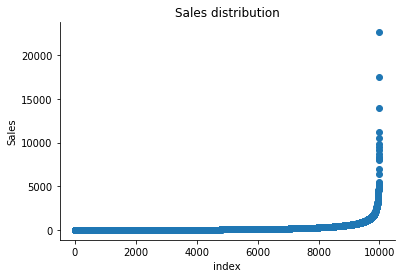

In [6]:
plt.scatter(range(df.shape[0]), np.sort(df['Sales'].values))
plt.xlabel('index')
plt.ylabel('Sales')
plt.title("Sales distribution")
sns.despine()

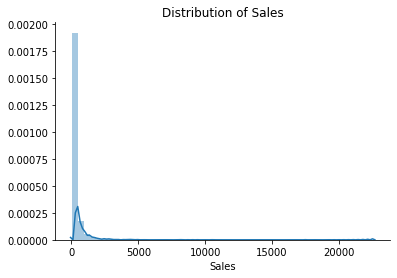

In [7]:
sns.distplot(df['Sales'])
plt.title("Distribution of Sales")
sns.despine()

In [8]:
print("Skewness: %f" % df['Sales'].skew())
print("Kurtosis: %f" % df['Sales'].kurt())

Skewness: 12.972752
Kurtosis: 305.311753


# Distribution of the Profit

In [9]:
df['Profit'].describe()

count    9994.000000
mean       28.656896
std       234.260108
min     -6599.978000
25%         1.728750
50%         8.666500
75%        29.364000
max      8399.976000
Name: Profit, dtype: float64

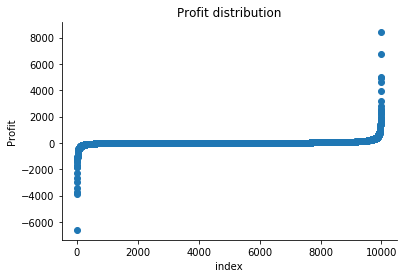

In [10]:
plt.scatter(range(df.shape[0]), np.sort(df['Profit'].values))
plt.xlabel('index')
plt.ylabel('Profit')
plt.title("Profit distribution")
sns.despine()

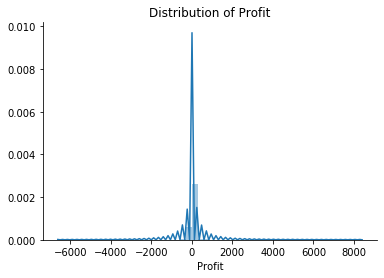

In [11]:
sns.distplot(df['Profit'])
plt.title("Distribution of Profit")
sns.despine()

In [12]:
print("Skewness: %f" % df['Profit'].skew())
print("Kurtosis: %f" % df['Profit'].kurt())

Skewness: 7.561432
Kurtosis: 397.188515


# Univariate Anomaly Detection on Sales

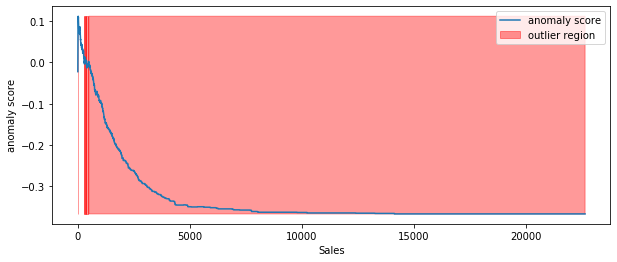

In [13]:
isolation_forest = IsolationForest(n_estimators=100)
isolation_forest.fit(df['Sales'].values.reshape(-1, 1))
xx = np.linspace(df['Sales'].min(), df['Sales'].max(), len(df)).reshape(-1,1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)
plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('Sales')
plt.show();

In [14]:
df.loc[df['Sales'] > 1500].head().transpose()

,10,27,149,165,167
Row ID,11,28,150,166,168
Order ID,CA-2014-115812,US-2015-150630,CA-2016-114489,CA-2014-139892,CA-2014-139892
Order Date,09/06/2014,17/09/2015,05/12/2016,08/09/2014,08/09/2014
Ship Date,14/06/2014,21/09/2015,09/12/2016,12/09/2014,12/09/2014
Ship Mode,Standard Class,Standard Class,Standard Class,Standard Class,Standard Class
Customer ID,BH-11710,TB-21520,JE-16165,BM-11140,BM-11140
Customer Name,Brosina Hoffman,Tracy Blumstein,Justin Ellison,Becky Martin,Becky Martin
Segment,Consumer,Consumer,Corporate,Consumer,Consumer
Country,United States,United States,United States,United States,United States
City,Los Angeles,Philadelphia,Franklin,San Antonio,San Antonio


# Visually investigate one anomaly

In [15]:
df.iloc[10]

Row ID                                                 11
Order ID                                   CA-2014-115812
Order Date                                     09/06/2014
Ship Date                                      14/06/2014
Ship Mode                                  Standard Class
Customer ID                                      BH-11710
Customer Name                             Brosina Hoffman
Segment                                          Consumer
Country                                     United States
City                                          Los Angeles
State                                          California
Postal Code                                         90032
Region                                               West
Product ID                                FUR-TA-10001539
Category                                        Furniture
Sub-Category                                       Tables
Product Name     Chromcraft Rectangular Conference Tables
Sales         

# Univariate Anomaly Detection on Profit

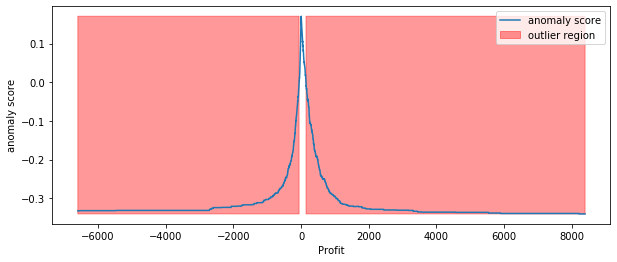

In [16]:
isolation_forest = IsolationForest(n_estimators=100)
isolation_forest.fit(df['Profit'].values.reshape(-1, 1))
xx = np.linspace(df['Profit'].min(), df['Profit'].max(), len(df)).reshape(-1,1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)
plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('Profit')
plt.show();

In [17]:
df.loc[df['Profit'] < -100].head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
3,4,US-2015-108966,11/10/2015,18/10/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
14,15,US-2015-118983,22/11/2015,26/11/2015,Standard Class,HP-14815,Harold Pawlan,Home Office,United States,Fort Worth,...,76106,Central,OFF-AP-10002311,Office Supplies,Appliances,Holmes Replacement Filter for HEPA Air Cleaner...,68.8100,5,0.80,-123.8580
27,28,US-2015-150630,17/09/2015,21/09/2015,Standard Class,TB-21520,Tracy Blumstein,Consumer,United States,Philadelphia,...,19140,East,FUR-BO-10004834,Furniture,Bookcases,"Riverside Palais Royal Lawyers Bookcase, Royal...",3083.4300,7,0.50,-1665.0522
36,37,CA-2016-117590,08/12/2016,10/12/2016,First Class,GH-14485,Gene Hale,Corporate,United States,Richardson,...,75080,Central,FUR-FU-10003664,Furniture,Furnishings,"Electrix Architect's Clamp-On Swing Arm Lamp, ...",190.9200,5,0.60,-147.9630
72,73,US-2015-134026,26/04/2015,02/05/2015,Standard Class,JE-15745,Joel Eaton,Consumer,United States,Memphis,...,38109,South,FUR-CH-10000513,Furniture,Chairs,High-Back Leather Manager's Chair,831.9360,8,0.20,-114.3912


## Visually investigate some of the anomalies

In [18]:
df.iloc[3]

Row ID                                                       4
Order ID                                        US-2015-108966
Order Date                                          11/10/2015
Ship Date                                           18/10/2015
Ship Mode                                       Standard Class
Customer ID                                           SO-20335
Customer Name                                   Sean O'Donnell
Segment                                               Consumer
Country                                          United States
City                                           Fort Lauderdale
State                                                  Florida
Postal Code                                              33311
Region                                                   South
Product ID                                     FUR-TA-10000577
Category                                             Furniture
Sub-Category                                           

In [19]:
df.loc[df['Profit'] > 200].head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
1,2,CA-2016-152156,08/11/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,3,0.0,219.5820
24,25,CA-2015-106320,25/09/2015,30/09/2015,Standard Class,EB-13870,Emily Burns,Consumer,United States,Orem,...,84057,West,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,1044.63,3,0.0,240.2649
54,55,CA-2016-105816,11/12/2016,17/12/2016,Standard Class,JM-15265,Janet Molinari,Corporate,United States,New York City,...,10024,East,TEC-PH-10002447,Technology,Phones,AT&T CL83451 4-Handset Telephone,1029.95,5,0.0,298.6855
144,145,CA-2017-155376,22/12/2017,27/12/2017,Standard Class,SG-20080,Sandra Glassco,Consumer,United States,Independence,...,64055,Central,OFF-AP-10001058,Office Supplies,Appliances,Sanyo 2.5 Cubic Foot Mid-Size Office Refrigera...,839.43,3,0.0,218.2518
149,150,CA-2016-114489,05/12/2016,09/12/2016,Standard Class,JE-16165,Justin Ellison,Corporate,United States,Franklin,...,53132,Central,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",1951.84,8,0.0,585.5520


In [20]:
df.iloc[1]

Row ID                                                           2
Order ID                                            CA-2016-152156
Order Date                                              08/11/2016
Ship Date                                               11/11/2016
Ship Mode                                             Second Class
Customer ID                                               CG-12520
Customer Name                                          Claire Gute
Segment                                                   Consumer
Country                                              United States
City                                                     Henderson
State                                                     Kentucky
Postal Code                                                  42420
Region                                                       South
Product ID                                         FUR-CH-10000454
Category                                                 Furni

# Multivariate Anomaly Detection

## Sales & Profit

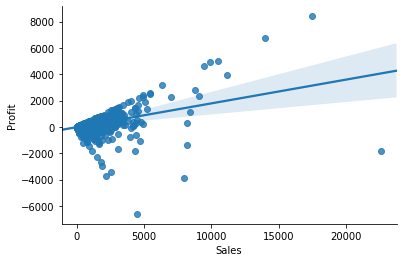

In [21]:
sns.regplot(x="Sales", y="Profit", data=df)
sns.despine();

In [22]:
cols = ['Sales', 'Profit']
df[cols].head()

,Sales,Profit
0,261.9600,41.9136
1,731.9400,219.5820
2,14.6200,6.8714
3,957.5775,-383.0310
4,22.3680,2.5164


In [23]:
minmax = MinMaxScaler(feature_range=(0, 1))
df[['Sales','Profit']] = minmax.fit_transform(df[['Sales','Profit']])
df[['Sales','Profit']].head()

,Sales,Profit
0,0.011552,0.442794
1,0.032313,0.454639
2,0.000626,0.440458
3,0.042280,0.414464
4,0.000968,0.440168


In [24]:
X1 = df['Sales'].values.reshape(-1,1)
X2 = df['Profit'].values.reshape(-1,1)

X = np.concatenate((X1,X2),axis=1)

## Cluster-based Local Outlier Factor (CBLOF)

OUTLIERS: 100 INLIERS: 9894


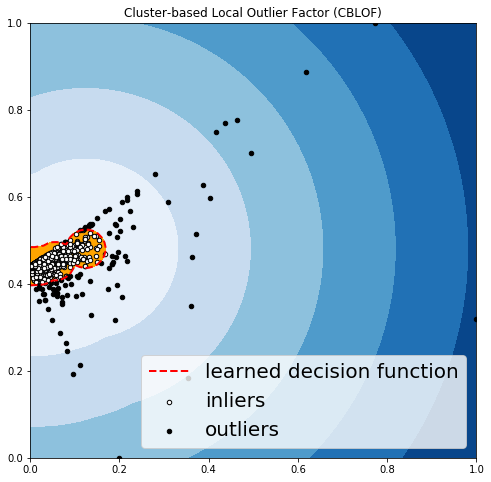

In [25]:
outliers_fraction = 0.01
xx , yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
clf = CBLOF(contamination=outliers_fraction,check_estimator=False, random_state=0)
clf.fit(X)
scores_pred = clf.decision_function(X) * -1
y_pred = clf.predict(X)
n_inliers = len(y_pred) - np.count_nonzero(y_pred)
n_outliers = np.count_nonzero(y_pred == 1)

plt.figure(figsize=(8, 8))

df1 = df
df1['outlier'] = y_pred.tolist()
    
# sales - inlier feature 1,  profit - inlier feature 2
inliers_sales = np.array(df1['Sales'][df1['outlier'] == 0]).reshape(-1,1)
inliers_profit = np.array(df1['Profit'][df1['outlier'] == 0]).reshape(-1,1)
    
# sales - outlier feature 1, profit - outlier feature 2
outliers_sales = df1['Sales'][df1['outlier'] == 1].values.reshape(-1,1)
outliers_profit = df1['Profit'][df1['outlier'] == 1].values.reshape(-1,1)
         
print('OUTLIERS:',n_outliers,'INLIERS:',n_inliers)
threshold = percentile(scores_pred, 100 * outliers_fraction)        
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')
plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')
b = plt.scatter(inliers_sales, inliers_profit, c='white',s=20, edgecolor='k')
    
c = plt.scatter(outliers_sales, outliers_profit, c='black',s=20, edgecolor='k')
       
plt.axis('tight')   
plt.legend([a.collections[0], b,c], ['learned decision function', 'inliers','outliers'],
           prop=matplotlib.font_manager.FontProperties(size=20),loc='lower right')      
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.title('Cluster-based Local Outlier Factor (CBLOF)')
plt.show();

## Histogram-based Outlier Detection (HBOS)

OUTLIERS: 90 INLIERS: 9904


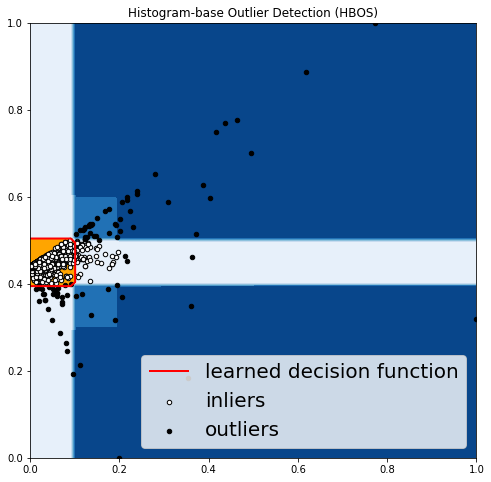

In [26]:
outliers_fraction = 0.01
xx , yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
clf = HBOS(contamination=outliers_fraction)
clf.fit(X)
# predict raw anomaly score
scores_pred = clf.decision_function(X) * -1
        
# prediction of a datapoint category outlier or inlier
y_pred = clf.predict(X)
n_inliers = len(y_pred) - np.count_nonzero(y_pred)
n_outliers = np.count_nonzero(y_pred == 1)
plt.figure(figsize=(8, 8))
# copy of dataframe
df1 = df
df1['outlier'] = y_pred.tolist()
    
# sales - inlier feature 1,  profit - inlier feature 2
inliers_sales = np.array(df1['Sales'][df1['outlier'] == 0]).reshape(-1,1)
inliers_profit = np.array(df1['Profit'][df1['outlier'] == 0]).reshape(-1,1)
    
# sales - outlier feature 1, profit - outlier feature 2
outliers_sales = df1['Sales'][df1['outlier'] == 1].values.reshape(-1,1)
outliers_profit = df1['Profit'][df1['outlier'] == 1].values.reshape(-1,1)
         
print('OUTLIERS:',n_outliers,'INLIERS:',n_inliers)
        
# threshold value to consider a datapoint inlier or outlier
threshold = percentile(scores_pred, 100 * outliers_fraction)
        
# decision function calculates the raw anomaly score for every point
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)
# fill blue map colormap from minimum anomaly score to threshold value
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)

# draw red contour line where anomaly score is equal to thresold
a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')
        
# fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')
b = plt.scatter(inliers_sales, inliers_profit, c='white',s=20, edgecolor='k')
    
c = plt.scatter(outliers_sales, outliers_profit, c='black',s=20, edgecolor='k')
       
plt.axis('tight')  
     
plt.legend([a.collections[0], b,c], ['learned decision function', 'inliers','outliers'],
           prop=matplotlib.font_manager.FontProperties(size=20),loc='lower right')
      
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.title('Histogram-base Outlier Detection (HBOS)')
plt.show();

##  Isolation Forest

OUTLIERS:  100 INLIERS:  9894


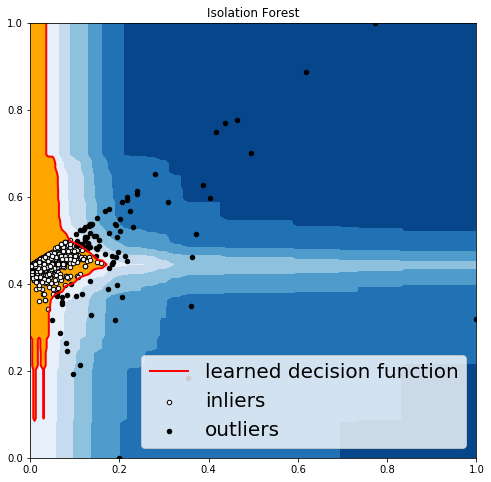

In [27]:
outliers_fraction = 0.01
xx , yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
clf = IForest(contamination=outliers_fraction,random_state=0)
clf.fit(X)
# predict raw anomaly score
scores_pred = clf.decision_function(X) * -1
        
# prediction of a datapoint category outlier or inlier
y_pred = clf.predict(X)
n_inliers = len(y_pred) - np.count_nonzero(y_pred)
n_outliers = np.count_nonzero(y_pred == 1)
plt.figure(figsize=(8, 8))
# copy of dataframe
df1 = df
df1['outlier'] = y_pred.tolist()
    
# sales - inlier feature 1,  profit - inlier feature 2
inliers_sales = np.array(df1['Sales'][df1['outlier'] == 0]).reshape(-1,1)
inliers_profit = np.array(df1['Profit'][df1['outlier'] == 0]).reshape(-1,1)
    
# sales - outlier feature 1, profit - outlier feature 2
outliers_sales = df1['Sales'][df1['outlier'] == 1].values.reshape(-1,1)
outliers_profit = df1['Profit'][df1['outlier'] == 1].values.reshape(-1,1)
         
print('OUTLIERS: ',n_outliers,'INLIERS: ',n_inliers)
        
# threshold value to consider a datapoint inlier or outlier
threshold = percentile(scores_pred, 100 * outliers_fraction)
        
# decision function calculates the raw anomaly score for every point
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)
# fill blue map colormap from minimum anomaly score to threshold value
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
        
# draw red contour line where anomaly score is equal to thresold
a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')
        
# fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')
b = plt.scatter(inliers_sales, inliers_profit, c='white',s=20, edgecolor='k')
    
c = plt.scatter(outliers_sales, outliers_profit, c='black',s=20, edgecolor='k')
       
plt.axis('tight')
plt.legend([a.collections[0], b,c], ['learned decision function', 'inliers','outliers'],
           prop=matplotlib.font_manager.FontProperties(size=20),loc='lower right')
      
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.title('Isolation Forest')
plt.show();

##  K - Nearest Neighbors (KNN)

OUTLIERS:  91 INLIERS:  9903


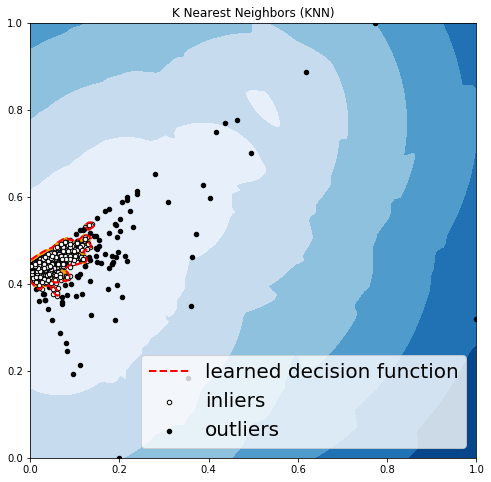

In [28]:
outliers_fraction = 0.01
xx , yy = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
clf = KNN(contamination=outliers_fraction)
clf.fit(X)
# predict raw anomaly score
scores_pred = clf.decision_function(X) * -1
        
# prediction of a datapoint category outlier or inlier
y_pred = clf.predict(X)
n_inliers = len(y_pred) - np.count_nonzero(y_pred)
n_outliers = np.count_nonzero(y_pred == 1)
plt.figure(figsize=(8, 8))
# copy of dataframe
df1 = df
df1['outlier'] = y_pred.tolist()
    
# sales - inlier feature 1,  profit - inlier feature 2
inliers_sales = np.array(df1['Sales'][df1['outlier'] == 0]).reshape(-1,1)
inliers_profit = np.array(df1['Profit'][df1['outlier'] == 0]).reshape(-1,1)
    
# sales - outlier feature 1, profit - outlier feature 2
outliers_sales = df1['Sales'][df1['outlier'] == 1].values.reshape(-1,1)
outliers_profit = df1['Profit'][df1['outlier'] == 1].values.reshape(-1,1)
         
print('OUTLIERS: ',n_outliers,'INLIERS: ',n_inliers)
        
# threshold value to consider a datapoint inlier or outlier
threshold = percentile(scores_pred, 100 * outliers_fraction)
        
# decision function calculates the raw anomaly score for every point
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)
# fill blue map colormap from minimum anomaly score to threshold value
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)

# draw red contour line where anomaly score is equal to thresold
a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')
        
# fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')
b = plt.scatter(inliers_sales, inliers_profit, c='white',s=20, edgecolor='k')
    
c = plt.scatter(outliers_sales, outliers_profit, c='black',s=20, edgecolor='k')
       
plt.axis('tight')  
   
plt.legend([a.collections[0], b,c], ['learned decision function', 'inliers','outliers'],
           prop=matplotlib.font_manager.FontProperties(size=20),loc='lower right')
      
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.title('K Nearest Neighbors (KNN)')
plt.show();

## Visually investigate some of the anomalies

In [29]:
df1.loc[df1['outlier'] == 1].tail(10).transpose()

,9231,9270,9412,9425,9639,9649,9660,9741,9774,9857
Row ID,9232,9271,9413,9426,9640,9650,9661,9742,9775,9858
Order ID,CA-2014-148383,US-2017-102183,CA-2015-164777,CA-2014-116246,CA-2015-116638,CA-2016-107104,CA-2016-160717,CA-2015-117086,CA-2014-169019,CA-2015-164301
Order Date,27/12/2014,21/08/2017,27/01/2015,12/09/2014,28/01/2015,26/11/2016,06/06/2016,08/11/2015,26/07/2014,26/03/2015
Ship Date,31/12/2014,28/08/2017,29/01/2015,17/09/2014,31/01/2015,30/11/2016,11/06/2016,12/11/2015,30/07/2014,30/03/2015
Ship Mode,Standard Class,Standard Class,First Class,Second Class,Second Class,Standard Class,Standard Class,Standard Class,Standard Class,Standard Class
Customer ID,RP-19390,PK-19075,SC-20305,LW-17215,JH-15985,MS-17365,ME-17320,QJ-19255,LF-17185,EB-13840
Customer Name,Resi P?lking,Pete Kriz,Sean Christensen,Luke Weiss,Joseph Holt,Maribeth Schnelling,Maria Etezadi,Quincy Jones,Luke Foster,Ellis Ballard
Segment,Consumer,Consumer,Consumer,Consumer,Consumer,Consumer,Home Office,Corporate,Consumer,Corporate
Country,United States,United States,United States,United States,United States,United States,United States,United States,United States,United States
City,Phoenix,New York City,Los Angeles,New York City,Concord,Los Angeles,Santa Barbara,Burlington,San Antonio,Seattle


In [30]:
df = pd.read_csv("Anomaly_dataset.csv", encoding='ISO-8859-1', header=0)

In [31]:
df.iloc[1995]

Row ID                                                        1996
Order ID                                            US-2017-147221
Order Date                                              02/12/2017
Ship Date                                               04/12/2017
Ship Mode                                             Second Class
Customer ID                                               JS-16030
Customer Name                                            Joy Smith
Segment                                                   Consumer
Country                                              United States
City                                                       Houston
State                                                        Texas
Postal Code                                                  77036
Region                                                     Central
Product ID                                         OFF-AP-10002534
Category                                           Office Supp

In [32]:
print("For this particular order, a customer purchased", df.iloc[1995]['Quantity'], "products with total price at $", df.iloc[1995]['Sales'], "and profit at lower than",int(df.iloc[1995]['Profit']), "with","{:.0%}".format(df.iloc[1995]['Discount']) ,"discount. It seems like a clearance. We should be aware of the loss for each product we sell")

For this particular order, a customer purchased 5 products with total price at $ 294.62 and profit at lower than -766 with 80% discount. It seems like a clearance. We should be aware of the loss for each product we sell


In [33]:
df.iloc[9649]

Row ID                                            9650
Order ID                                CA-2016-107104
Order Date                                  26/11/2016
Ship Date                                   30/11/2016
Ship Mode                               Standard Class
Customer ID                                   MS-17365
Customer Name                      Maribeth Schnelling
Segment                                       Consumer
Country                                  United States
City                                       Los Angeles
State                                       California
Postal Code                                      90045
Region                                            West
Product ID                             FUR-BO-10002213
Category                                     Furniture
Sub-Category                                 Bookcases
Product Name     DMI Eclipse Executive Suite Bookcases
Sales                                          3406.66
Quantity  

In [34]:
print("For this purchase, it seems to me that the profit at around", "{:.1%}".format(df.iloc[9649]['Profit']/df.iloc[9649]['Sales']) ,"is too small and the model determined that this order is an anomaly")

For this purchase, it seems to me that the profit at around 4.7% is too small and the model determined that this order is an anomaly


In [35]:
df.iloc[9270]

Row ID                                                 9271
Order ID                                     US-2017-102183
Order Date                                       21/08/2017
Ship Date                                        28/08/2017
Ship Mode                                    Standard Class
Customer ID                                        PK-19075
Customer Name                                     Pete Kriz
Segment                                            Consumer
Country                                       United States
City                                          New York City
State                                              New York
Postal Code                                           10035
Region                                                 East
Product ID                                  OFF-BI-10001359
Category                                    Office Supplies
Sub-Category                                        Binders
Product Name     GBC DocuBind TL300 Elec

In [36]:
print("For the above order, a customer purchased", df.iloc[9270]['Quantity'], "products at $", int(df.iloc[9270]['Sales']), "in total price, after a","{:.0%}".format(df.iloc[9270]['Discount']), "discount, we still get ", "{:.1%}".format(df.iloc[9270]['Profit']/df.iloc[9270]['Sales']) ,"of the profit. We would love to have more of these kind of anomalies.")

For the above order, a customer purchased 6 products at $ 4305 in total price, after a 20% discount, we still get  33.8% of the profit. We would love to have more of these kind of anomalies.
